In [1]:
import tensorflow as tf
import numpy as np
import sample_simulated_data as ssd
import drs_utils as drs
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N = 2 #number of neurons
types_of_trials = 2
samples_per_type = 500
R = types_of_trials * samples_per_type #total number of trials
xs = np.linspace(0,10,101)
T = 10.0 #time interval
d = 2 #dimension of latent space
L = 2 #number of epsilons used for each x_{r,i} in the minibatch
batch_size = 2 #batching over trials
n_intervals = 10
nodes = np.linspace(0.0, T, n_intervals+1, dtype='float32') #spline nodes are fixed here, learning them causes numerical instability
p = 3 #degree of polynomial used in each interval
s1 = p/2 + 1 #Q1 is s1 x s1
s2 = (p + 1)/2 #Q2 is s2 x s2
smooth = 2
units_mu = 100
units_sigma = 100
units_f = [100, 100, 100, (s1**2 + s2**2) * n_intervals * N] #last layer should output the number of parameters used to parametrize the splines
lr = 0.001 #learning rate
alt_steps = 53
max_epochs = 4 #number of epochs
# logdir = ...

In [3]:
# Generate simulated data
mu = np.zeros(len(xs)) + 0.5
sigma2 = 1.0
np.random.seed(2480)

S_all, mask_all, lengths_all, max_lengths, ys_all = ssd.create_data_set(xs, N, types_of_trials,
                                                                        int(1.2*samples_per_type), mu, sigma2, ssd.RBF)
aux_indices = np.random.choice(int(R * 1.2), int(R * 1.2), replace=False)
train_indices = aux_indices[:R]
test_indices = aux_indices[R:]
S_tensor = S_all[:,train_indices,:]
S_tensor_test = S_all[:,test_indices,:]
mask_tensor = mask_all[:,train_indices,:]
mask_tensor_test = mask_all[:,test_indices,:]
lengths = lengths_all[:, train_indices]
lengths_test = lengths_all[:, test_indices]
ys = ys_all[:,train_indices,:]
ys_test = ys_all[:,test_indices,:]

In [4]:
# auxiliary class for obtaining batches
class PermManager(object):
    def __init__(self, n, batch_size, perm=None, perm_index=0, epoch=0):
        assert batch_size <= n
        self.n = n
        self.batch_size = batch_size
        if perm is None:
            self.perm = np.random.permutation(self.n)
        else:
            self.perm = perm
        self.perm_index = perm_index
        self.epoch = epoch
        
    def get_indices(self):
        if self.perm_index + self.batch_size < self.n:
            indices = self.perm[self.perm_index:self.perm_index+self.batch_size]
            self.perm_index = self.perm_index + self.batch_size
        elif self.perm_index + self.batch_size == self.n:
            indices = self.perm[self.perm_index:self.perm_index+self.batch_size]
            self.perm_index = 0
            self.perm = np.random.permutation(self.n)
            self.epoch = self.epoch + 1
        else:
            surplus = self.perm_index + self.batch_size - self.n
            indices1 = self.perm[self.perm_index:]
            self.perm = np.random.permutation(self.n)
            indices2 = self.perm[:surplus]
            indices = np.concatenate((indices1, indices2), axis=0)
            self.perm_index = surplus
            self.epoch = self.epoch + 1
        return indices

In [5]:
# define tensorflow graph
tf.reset_default_graph()

eps = tf.placeholder(tf.float32, shape=(None, L, d))
X = tf.placeholder(tf.float32, shape=(N, None, max_lengths))
lengths_tf = tf.placeholder(tf.int32, shape=(N, None))
Y = tf.tile(tf.reshape(X, [N, -1, 1, max_lengths]), [1, 1, L, 1]) # repeat X

#transform eps into Z, result should be [batch_size*L, d]
mu = drs.mu_rnns(X, units_mu, lengths_tf, N, d) #[batch_size, d]
sigma = drs.sigma_rnns(X, units_sigma, lengths_tf, N, d) #[batch_size, d]
mu_repeat = tf.reshape(tf.tile(tf.reshape(mu, [-1, 1, d]), [1, L, 1]), [-1, d])
sigma_repeat = tf.reshape(tf.tile(tf.reshape(sigma, [-1, 1, d]), [1, L, 1]), [-1, d])
Z = mu_repeat + sigma_repeat * tf.reshape(eps, [-1, d])

#transform the hidden variable to the parameters of the PP
#Q1s has shape [N,batch_size,L,n_intervals,s1,s1] and Q2s [N,batch_size,L,n_intervals,s2,s2]
Q1s, Q2s = drs.f_nn(Z, units_f, alt_steps, nodes, n_intervals, p, s1, s2, N, L, smooth)

#compute the log density of y|z where x (y) given z (eta) is a PP
mask_tf = tf.placeholder(tf.float32, shape=(N, None, max_lengths)) #None here should be batch_size
mask_repeat = tf.tile(tf.reshape(mask_tf, [N, -1, 1, max_lengths]), [1, 1, L, 1])
log_p = tf.reduce_sum(drs.log_intensities(Y, Q1s, Q2s, nodes, mask_repeat, L, max_lengths, n_intervals, p, s1, s2, N,
                                          T, 0.001)) - tf.reduce_sum(drs.integral(Q1s, Q2s, nodes, p, N, L, s1, s2))
log_p = R / (batch_size * L) * log_p

#compute the KL (variational posterior to prior)
neg_KL = 0.5 * tf.reduce_sum(1.0 + 2.0 * tf.log(sigma) - mu**2 - sigma**2)
neg_KL = R / batch_size * neg_KL

#optimize
cost = - (log_p + neg_KL)
optim = tf.train.AdamOptimizer(learning_rate=lr)
all_params = tf.trainable_variables()
grads_and_vars = optim.compute_gradients(cost, all_params)
clipped_grads_and_vars = [(tf.clip_by_value(grad, -1.0, 1.0), var) for grad, var in grads_and_vars]
optimizer = optim.apply_gradients(clipped_grads_and_vars)

#saver = tf.train.Saver(tf.global_variables())
#summary_op = tf.summary.merge_all()

init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

#summary_writer = tf.summary.FileWriter(logdir, graph=sess.graph)

#ckpt_state = tf.train.get_checkpoint_state(logdir)
#if ckpt_state and ckpt_state.model_checkpoint_path:
#    saver.restore(sess, ckpt_state.model_checkpoint_path)

In [6]:
# train the model
def epoch_cost(R_train, batch_size, X_eval, mask_eval, lengths_eval):
    assert np.shape(X_eval)[1] % batch_size == 0
    negative_ELBO = 0.0
    local_perms = PermManager(np.shape(X_eval)[1], batch_size)
    while local_perms.epoch < 1:
        eps_batch = np.random.normal(size=[batch_size, L, d])
        batch = local_perms.get_indices()
        X_batch = X_eval[:, batch, :]
        mask_batch = mask_eval[:, batch, :]
        lengths_batch = lengths_eval[:, batch]
        negative_ELBO += sess.run(cost, {eps: eps_batch, X: X_batch, mask_tf: mask_batch, lengths_tf: lengths_batch})
    negative_ELBO = negative_ELBO * batch_size / R_train
    del local_perms
    return negative_ELBO

train_costs = []
test_costs = []
perms = PermManager(R, batch_size)
while True:
    start_epoch = perms.epoch
    eps_batch = np.random.normal(size=[batch_size, L, d])
    batch = perms.get_indices()
    X_batch = S_tensor[:, batch, :]
    mask_batch = mask_tensor[:, batch, :]
    lengths_batch = lengths[:, batch]
    #_, summary = sess.run([optimizer, summary_op], {eps: eps_batch, X: X_batch, mask_tf: mask_batch, lengths_tf: lengths_batch})
    #summary_writer.add_summary(summary, step)
    _, c = sess.run([optimizer, cost], {eps: eps_batch, X: X_batch, mask_tf: mask_batch, lengths_tf: lengths_batch})
    if perms.epoch > start_epoch:
        train_costs.append(epoch_cost(R, batch_size, S_tensor, mask_tensor, lengths))
        test_costs.append(epoch_cost(R, batch_size, S_tensor_test, mask_tensor_test, lengths_test))
        print('epoch '+str(start_epoch)+' done with cost '+str(train_costs[-1]))
    #if step % 1000 == 0 or step + 1 == max_iter:
    #    checkpoint_path = os.path.join(logdir, 'model.ckpt')
    #    saver.save(sess, checkpoint_path)
    if perms.epoch >= max_epochs:
        break

epoch 0 done with cost -52558.54934790039
epoch 1 done with cost -55146.90563793945
epoch 2 done with cost -36491.47328515625
epoch 3 done with cost -54656.52669348144


In [7]:
print -test_costs[-1] / 200.0

56.38085600585938


/Users/multivac/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


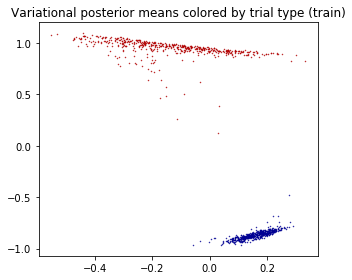

In [8]:
mu_final = sess.run(mu, {X:S_tensor, lengths_tf:lengths})
plt.figure(figsize=(5,4))
color_idx = np.linspace(0.1,0.9,types_of_trials)
for r in xrange(R):
    r_type = train_indices[r] % types_of_trials
    plt.scatter(mu_final[r,0], mu_final[r,1], color=plt.cm.seismic(color_idx[r_type]), s=0.2)
plt.title("Variational posterior means colored by trial type (train)")
plt.legend()
plt.tight_layout()

#plt.savefig("simulated_spline_posterior_means_train.pdf")

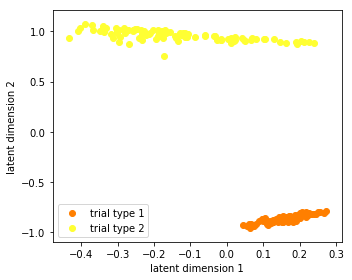

In [9]:
blue = (55.0 / 255.0, 126.0 / 255.0, 184.0 / 255.0)
red = (228.0 / 255.0, 26.0 / 255.0, 28.0 / 255.0)
orange = (255.0 / 255.0, 127.0 / 255.0, 0.0 / 255.0)
yellow = (255.0 / 255.0, 255.0 / 255.0, 51.0 / 255.0)
mu_final_test = sess.run(mu, {X:S_tensor_test, lengths_tf:lengths_test})
plt.figure(figsize=(5,4))
color_list = [orange, yellow]
for r in xrange(int(0.2 * R)):
    r_type = test_indices[r] % types_of_trials
    if r < 2:
        plt.scatter(mu_final_test[r,0], mu_final_test[r,1], color=color_list[r_type], label='trial type '+str(r_type+1))
    else:
        plt.scatter(mu_final_test[r,0], mu_final_test[r,1], color=color_list[r_type])
# plt.title("Variational posterior means colored by trial type")
plt.legend()
plt.xlabel('latent dimension 1')
plt.ylabel('latent dimension 2')
plt.tight_layout()

# plt.savefig("simulated_spline_posterior_means_test_poster.pdf")

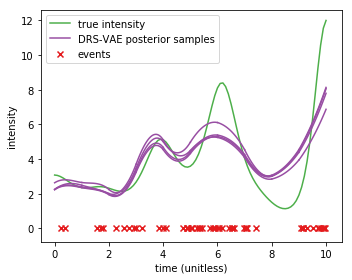

In [10]:
neuron = 0
trial = 1
S_trial = S_tensor_test[:,[trial],:]
lengths_trial = lengths_test[:, [trial]]
Q1s_samples_0, Q2s_samples_0 = sess.run([Q1s, Q2s], {X:S_trial, eps:np.random.normal(size=[1, L, d]), lengths_tf:lengths_trial})
Q1s_samples_1, Q2s_samples_1 = sess.run([Q1s, Q2s], {X:S_trial, eps:np.random.normal(size=[1, L, d]), lengths_tf:lengths_trial})

def compute_spline(xs, Q1s, Q2s, neuron, l, interval, p, r=0):
    #only works for quadratic and cubic splines
    Q1 = Q1s[neuron, r, l, interval,:,:]
    Q2 = Q2s[neuron, r, l, interval,:,:]
    if p == 2:
        pol1 = Q1[0,0] + (Q1[0,1] + Q1[1,0]) * xs + Q1[1,1] * xs**2
        pol2 = Q2[0,0] * (xs - nodes[interval]) * (nodes[interval+1] - xs)
    if p == 3:
        pol1 = (nodes[interval+1] - xs) * (Q1[0,0] + (Q1[0,1] + Q1[1,0]) * xs + Q1[1,1] * xs**2)
        pol2 = (xs - nodes[interval]) * (Q2[0,0] + (Q2[0,1] + Q2[1,0]) * xs + Q2[1,1] * xs**2)
    return(pol1+pol2)

green = (77.0 / 255.0, 175.0 / 255.0, 74.0 / 255.0)
purple = (152.0 / 255.0, 78.0 / 255.0, 163.0 / 255.0)
red = (228.0 / 255.0, 26.0 / 255.0, 28.0 / 255.0)

plt.figure(figsize=(5,4))
plt.plot(xs, ys_test[neuron,trial,:], color=green, label="true intensity")
plt.scatter(S_tensor_test[neuron,trial,:lengths_test[neuron,trial]], np.zeros(lengths_test[neuron,trial]), color=red, label="events", marker='x')
# plt.title("Inferred intensity for a simulated spike train")
plt.xlabel('time (unitless)')
plt.ylabel('intensity')
for i in xrange(n_intervals):
    xs_loc = np.linspace(nodes[i], nodes[i+1], 25)
    ys_0 = compute_spline(xs_loc, Q1s_samples_0, Q2s_samples_0, neuron, 0, i, p)
    if i == 0:
        plt.plot(xs_loc, ys_0, color=purple, label="DRS-VAE posterior samples")
    else:
        plt.plot(xs_loc, ys_0, color=purple)
    ys_1 = compute_spline(xs_loc, Q1s_samples_0, Q2s_samples_0, neuron, 1, i, p)
    plt.plot(xs_loc, ys_1, color=purple)
    ys_2 = compute_spline(xs_loc, Q1s_samples_1, Q2s_samples_1, neuron, 0, i, p)
    plt.plot(xs_loc, ys_2, color=purple)
    ys_3 = compute_spline(xs_loc, Q1s_samples_1, Q2s_samples_1, neuron, 1, i, p)
    plt.plot(xs_loc, ys_3, color=purple)

plt.legend()
plt.tight_layout()

# plt.savefig("simulated_spline_intensities.pdf")

In [11]:
def l2_distance(ys_true, ys, xs):
    # ys_true and ys have shape [R, N, len(xs)] and each represent RN functions, each evaluated at each point in xs,
    # which has shape [len(xs)].
    # the output has shape [R, N] and approximates the l2 distance between ys_true and ys for every function.
    T = xs[-1] - xs[0]
    widths = xs[1:] - xs[:-1]
    heights = ((ys_true[:,:,1:] + ys_true[:,:,:-1]) / 2.0 - (ys[:,:,1:] + ys[:,:,:-1]) / 2.0)**2
    l2s = np.sqrt(np.sum(np.reshape(widths, [1, 1, -1]) * heights, axis=2))
    return(l2s)

def compute_all_splines(xs, Q1s, Q2s, l, p):
    # returns an array of shape [R, N, len(xs)] where the [r,n,i] entry corresponds to the value of the spline
    # of the r-th trial, n-th neuron at xs[i] for sample l (Q1s and Q2s have shape [N, R, L, n_intervals, ?, ?])
    N, R, _, n_intervals, _, _ = np.shape(Q1s)
    out = []
    for n in xrange(N):
        for r in xrange(R):
            local_out = []
            for interval in xrange(n_intervals):
                if interval == 0:
                    local_xs = xs[np.logical_and(xs>=nodes[interval], xs<=nodes[interval+1])]
                else:
                    local_xs = xs[np.logical_and(xs>nodes[interval], xs<=nodes[interval+1])]
                local_out = np.concatenate((local_out, compute_spline(local_xs, Q1s, Q2s, n, l, interval, p, r)))
            out.append(np.reshape(local_out, [-1]))

    return(np.transpose(np.reshape(out, [N, R, -1]), [1, 0, 2]))

Q1s_samples_test_0, Q2s_samples_test_0 = sess.run([Q1s, Q2s], {X:S_tensor_test, eps:np.random.normal(size=[200, L, d]), lengths_tf:lengths_test})
drs_y = compute_all_splines(xs, Q1s_samples_test_0, Q2s_samples_test_0, 0, 3)
drs_l2s = l2_distance(np.transpose(ys_test, [1, 0, 2]), drs_y, xs) / 40.0
print 'average l2 distance from posterior samples to truth for DRS: ' + str(np.mean(drs_l2s)) +'+-' + str(np.std(drs_l2s))

average l2 distance from posterior samples to truth for DRS: 0.11320676797909111+-0.07373485470305692
